## Note
This one is based on file Turot_0.ipynb, it enlarges the total data from 1000+ to 8000+. The sacrifice is training data is not semiconductor anymore. The data used in Turot_0 will be used as test data set. 

length of 3 elem data is  7293

length of 2 elem data is  1230

This is just for setup, the real test has been done at HPC.

### define Save and load function

In [3]:
from six.moves import cPickle as pickle
def loadFromPickle(pickle_file):
    #pickle_file = 'SemiDataBase.pickle'
    with open(pickle_file, 'rb') as f:
      save = pickle.load(f)
      database= save['database']
      del save  # hint to help gc free up memory
    return database

def saveTopickle(pickle_file_name,database):
 try:
  f = open(pickle_file_name, 'wb')
  save = {
    'database':database,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
 except Exception as e:
  print('Unable to save data to', pickle_file_name, ':', e)
  raise

### Load the saved Data and peak at it

In [19]:
test=[]
test=loadFromPickle('SemiDataBase.pickle')
print "length of data is: "+str(len(test))
for key in test[11]:
    if key not in ['cif','spacegroup']:
        print key,">>>>>>>>>>>>>>>>>>>>>",test[11][key]

length of data is: 1530
icsd_ids >>>>>>>>>>>>>>>>>>>>> [41898]
energy >>>>>>>>>>>>>>>>>>>>> -34.22314566
elasticity >>>>>>>>>>>>>>>>>>>>> None
unit_cell_formula >>>>>>>>>>>>>>>>>>>>> {u'S': 4.0, u'Ba': 1.0, u'Ag': 2.0, u'Sn': 1.0}
oxide_type >>>>>>>>>>>>>>>>>>>>> None
hubbards >>>>>>>>>>>>>>>>>>>>> {}
task_ids >>>>>>>>>>>>>>>>>>>>> [u'mp-702596', u'mp-682621', u'mp-667121', u'mp-555166']
band_gap >>>>>>>>>>>>>>>>>>>>> 0.3603
e_above_hull >>>>>>>>>>>>>>>>>>>>> 0
nsites >>>>>>>>>>>>>>>>>>>>> 8
icsd_id >>>>>>>>>>>>>>>>>>>>> 41898
elements >>>>>>>>>>>>>>>>>>>>> [u'Ag', u'Ba', u'S', u'Sn']
tags >>>>>>>>>>>>>>>>>>>>> [u'Disilver barium tetrathiostannate(IV)']
pretty_formula >>>>>>>>>>>>>>>>>>>>> BaAg2SnS4
volume >>>>>>>>>>>>>>>>>>>>> 208.04569394
total_magnetization >>>>>>>>>>>>>>>>>>>>> 0.0
is_hubbard >>>>>>>>>>>>>>>>>>>>> False
formation_energy_per_atom >>>>>>>>>>>>>>>>>>>>> -1.09570473828
nelements >>>>>>>>>>>>>>>>>>>>> 4
density >>>>>>>>>>>>>>>>>>>>> 4.7892306528
is_compatible >>>>>>>>>>

### Define a function to take a look at the data

In [25]:
from pymatgen import MPRester, periodic_table
from pymatgen import Composition, Element
import itertools
#########################fucntion to display data set in a periodic table format
def displayInPeriodicTable(database,showElementsTable=True):
    list2=[]
    w, h = 18, 9;
    Matrix = [['**' for x in range(w)] for y in range(h)] 
    Matrix2 = [[0 for x in range(w)] for y in range(h)] 

    for data in database:
        for elem in data["elements"]:
    #         elem.row()
            if elem not in list2:
                list2.append(elem)
                Matrix[Element(elem).row-1][Element(elem).group-1]=elem
    for data in database:
        for elem in data["elements"]:          
                Matrix2[Element(elem).row-1][Element(elem).group-1]=Matrix2[Element(elem).row-1][Element(elem).group-1]+1
    if showElementsTable:
        print "elements appear in the dataset"
        print "#"*94
        for row in range(h): 
            print "#",
            for col in range(w):
                print '%4s' % Matrix[row][col],
            print " #",
            print
        print "#"*94
    print "Count of the elements appearance"
    print "#"*94
    for row in range(h): 
        print "#",
        for col in range(w):
            print '%4d' % Matrix2[row][col],
        print " #",
        print
    print "#"*94
#########################fucntion to display data set in a periodic table format

In [146]:
train=loadFromPickle('FullRawData3Elem2Elem_dropRepeat')
displayInPeriodicTable(train)
print "in test data set"
test=loadFromPickle('SemiDataBase.pickle')
displayInPeriodicTable(test,False)

elements appear in the dataset
##############################################################################################
#    H   **   **   **   **   **   **   **   **   **   **   **   **   **   **   **   **   **  #
#   Li   Be   **   **   **   **   **   **   **   **   **   **    B    C    N    O    F   **  #
#   Na   Mg   **   **   **   **   **   **   **   **   **   **   Al   Si    P    S   Cl   **  #
#    K   Ca   Sc   Ti    V   Cr   Mn   Fe   Co   Ni   Cu   Zn   Ga   Ge   As   Se   Br   **  #
#   Rb   Sr    Y   Zr   Nb   Mo   Tc   Ru   Rh   Pd   Ag   Cd   In   Sn   Sb   Te    I   **  #
#   Cs   Ba   **   Hf   Ta    W   Re   Os   Ir   Pt   Au   Hg   Tl   Pb   Bi   **   **   **  #
#   **   **   **   **   **   **   **   **   **   **   **   **   **   **   **   **   **   **  #
#   **   **   La   Ce   Pr   Nd   **   Sm   Eu   Gd   Tb   Dy   Ho   Er   Tm   Yb   Lu   **  #
#   **   **   **   Th   **    U   **   **   **   **   **   **   **   **   **   **   **   **  #
###################

## manipulate the data(make into traning data set format)

This step will make three data sets, PTFeatures will be vectors with (9x18) dimensions represents the elements in periodic table. bandgaps will contains all the bandgap info.

In [147]:
import numpy as np
def PeriodicTableVectorize(composition):
    vector = np.zeros((9,18)) # size of periodic table
    for element in composition:
        fraction = composition.get_atomic_fraction(element)
        vector[element.row-1,element.group-1] = fraction
    return vector

def formatData(database):
    materials=[]
    bandgaps=[]
    PTFeatures = []
    for item in database:
        materials.append(item["full_formula"])
        bandgaps.append(item["band_gap"])
    for item in materials:
       material = Composition(item)
       PTFeatures.append(PeriodicTableVectorize(material)) #create features from chemical formula
    return materials,PTFeatures,bandgaps

def reformat1D(dataset, labels):
    dataset=np.asarray(dataset)
    labels=np.asarray(labels)
    dataset = dataset.reshape((-1, dataset.shape[1] * dataset.shape[2])).astype(np.float32)
    labels = (labels[:,None]).astype(np.float32)
    return dataset, labels

train_material,train_vec,train_bandgaps=formatData(train)
test_material,test_vec,test_bandgaps=formatData(test)
train_1d,train_label=reformat1D(train_vec,train_bandgaps)
test_1d,test_label=reformat1D(test_vec,test_bandgaps)
print "train data dimensions is", train_1d.shape
print "train label dimensions is", train_label.shape
print "test data dimensions is", test_1d.shape
print "test label dimensions is", test_label.shape

train data dimensions is (7299, 162)
train label dimensions is (7299, 1)
test data dimensions is (1530, 162)
test label dimensions is (1530, 1)


### Now let's concatenate train with csv file data
the real data is not using from csv file

In [102]:
# trainFile = open("bandgapDFT.csv","r").readlines()
def ReadDataFromCSV(Filename="bandgapDFT.csv"):
    bandgaps = []
    naiveFeatures = []
    trainFile = open(Filename,"r").readlines()
    for line in trainFile:
           split = str.split(line, ',')
           material = Composition(split[0])
           naiveFeatures.append(PeriodicTableVectorize(material)) #create features from chemical formula
           bandgaps.append(float(split[1])) #store numerical values of band gaps
    return naiveFeatures,bandgaps

### a function to limit the bandgat between 0 and 10
def ReadDataFromCSV_Trim(Filename="bandgapDFT.csv"):
    bandgaps = []
    naiveFeatures = []
    materials=[]
    trainFile = open(Filename,"r").readlines()
    for line in trainFile:
           split = str.split(line, ',')
           if float(split[1])>0.1 and float(split[1])<10:
               material = Composition(split[0])
               materials.append(split[0])
               naiveFeatures.append(PeriodicTableVectorize(material)) #create features from chemical formula
               bandgaps.append(float(split[1])) #store numerical values of band gaps
    return naiveFeatures,bandgaps,materials
    

# train_csv,label_csv,materials_csv=ReadDataFromCSV_Trim()
# train_1d_csv,lebel_1d_csv=reformat1D(train_csv,label_csv)
# print "train csv data dimensions is", train_1d_csv.shape
# print "label csv data dimensions is", lebel_1d_csv.shape
            
#tmp1=np.concatenate((train_1d,train_1d_csv ), axis=0)

## plot everyting in histgram

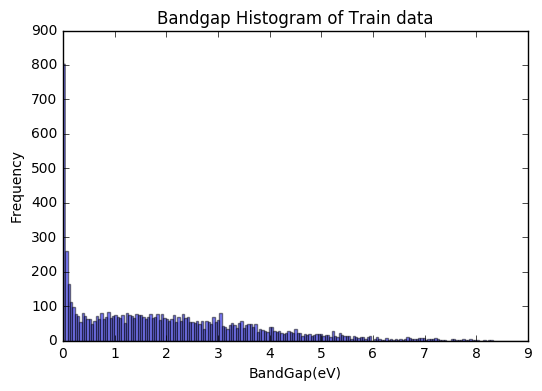

mean of Train datadata is 1.97 eV
median of Train data data is 1.69 eV


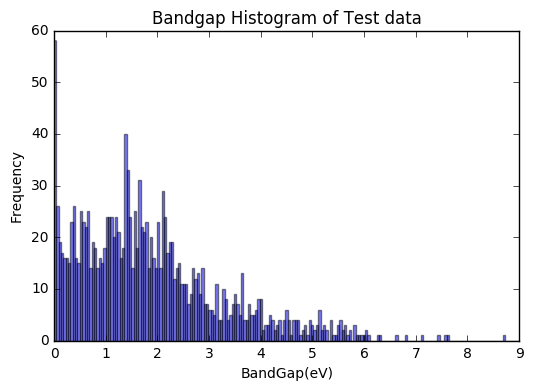

mean of Test datadata is 1.85 eV
median of Test data data is 1.59 eV


In [149]:
import matplotlib.pyplot as plt
#import plotly.plotly as py
def HistBandgap(bandgap,label="labels"):
    bins = np.linspace(0, 9, 200)
    plt.hist(bandgap,bins,alpha=0.5)
    plt.title("Bandgap Histogram of "+label)
    plt.xlabel("BandGap(eV)")
    plt.ylabel("Frequency")
    #plt.text(3, bandgap.max(), "mean of data is "+str(np.around(np.mean(bandgap),decimals=2))+" eV")
    #plt.text(3, 80, "median of data is "+str(np.around(np.median(bandgap),decimals=2))+" eV")
    plt.show()
    print "mean of " +label+"data is "+str(np.around(np.mean(bandgap),decimals=2))+" eV"
    print "median of " +label+" data is "+str(np.around(np.median(bandgap),decimals=2))+" eV"
HistBandgap(train_label,"Train data")
HistBandgap(test_label,"Test data")


## Randamize the data

In [150]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
# train_dataset, train_labels = randomize(train_dataset, train_labels)
# test_dataset, test_labels = randomize(test_dataset, test_labels)
# valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

# shuffle  the data
train_1d,train_label=randomize(train_1d,train_label)
test_1d,test_label=randomize(test_1d,test_label)

## Save machine learning data to pickle

In [153]:
from six.moves import cPickle as pickle
pickle_file = 'VectorRep_Bandgap.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_1d':train_1d,
    'train_label':train_label,
    'test_1d':test_1d,
    'test_label':test_label,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

## Load machine learning data to pickle 

In [154]:
from six.moves import cPickle as pickle
pickle_file = 'VectorRep_Bandgap.pickle'
with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_1d = save['train_1d']
  train_label = save['train_label']
  test_1d = save['test_1d']
  test_label = save['test_label']  
  del save  # hint to help gc free up memory

train_dataset=train_1d
train_labels=train_label
test_dataset=test_1d
test_labels=test_label

# Machine learning
## Linear Regression

In [155]:
train_labels=train_label
baselineError = np.mean(abs(np.mean(train_labels) - train_labels))
print("The MAE of always guessing the average band gap of train data is: " + str(round(baselineError, 3)) + " eV")
test_label
baselineError = np.mean(abs(np.mean(test_label) - test_label))
print("The MAE of always guessing the average band gap of test data is: " + str(round(baselineError, 3)) + " eV")

The MAE of always guessing the average band gap of train data is: 1.38 eV
The MAE of always guessing the average band gap of test data is: 1.086 eV


The MAE of the linear ridge regression band gap model using the train set is: 0.893 eV


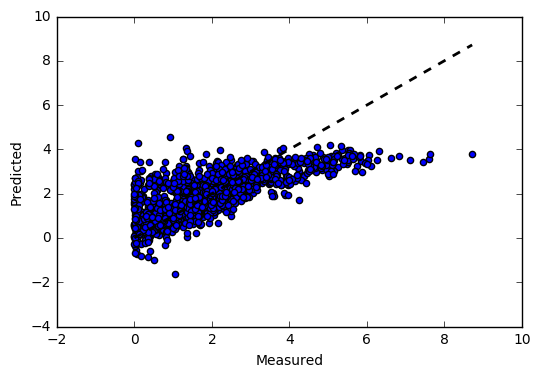

The MAE of the linear ridge regression band gap model using the test set is: 0.7 eV


In [156]:
# Train linear ridge regression model using naive feature set
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn import linear_model, cross_validation, metrics, ensemble

# train_dataset=Fulldata[0:1300]
# train_labels=labels[0:1300]
# test_dataset=Fulldata[1300:1531]
# test_labels=labels[1300:1531]
train_dataset=train_1d
train_labels=train_label
test_dataset=test_1d
test_labels=test_label

num_samples=train_dataset.shape[0]
#this won't work if num_samples are too small, if num_samples is too small, all Y is 0( the first number type), so it has to be large engouh

# (samples, width, height) = train_dataset.shape
# X = np.reshape(train_dataset,(samples,width*height))[0:num_samples]
# Y = train_labels[0:num_samples]


# X = np.concatenate((train_dataset,test_dataset),axis=0)
# Y = np.concatenate((train_labels,test_labels),axis=0)

X=train_dataset
Y=train_labels

Xt=test_dataset
Yt=test_labels

#alpha is a tuning parameter affecting how regression deals with collinear inputs
linear = linear_model.Ridge(alpha = 0.6)  

cv = cross_validation.ShuffleSplit(len(Y),n_iter=10, test_size=0.1, random_state=0)

scores = cross_validation.cross_val_score(linear, X,Y, cv=cv, scoring='mean_absolute_error')

print("The MAE of the linear ridge regression band gap model using the train set is: "+ str(round(abs(np.mean(scores)), 3)) + " eV")
############# plot it##########################################
# from sklearn.model_selection import cross_val_predict
# predicted = cross_val_predict(linear, X, Y, cv=10)
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# ax.scatter(Y, predicted)
# ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2)
# ax.set_xlabel('Measured')
# ax.set_ylabel('Predicted')
# plt.show()
############# plot it##########################################
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(linear, Xt, Yt, cv=10)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Yt, predicted)
ax.plot([Yt.min(), Yt.max()], [Yt.min(), Yt.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

cv = cross_validation.ShuffleSplit(len(Yt),n_iter=10, test_size=0.1, random_state=0)
scores = cross_validation.cross_val_score(linear, Xt,Yt, cv=cv, scoring='mean_absolute_error')
print("The MAE of the linear ridge regression band gap model using the test set is: "+ str(round(abs(np.mean(scores)), 3)) + " eV")

## Neural networks
### without hidden layer

In [157]:
print len(test_dataset)
print len(train_dataset)
Fulldata=train_dataset
labels=train_labels

1530
7299


In [168]:
Fulldata.shape

(7299, 162)

In [165]:
# image_size = 28
num_labels = 1
train_end=6500

train_dataset=Fulldata[:train_end]
train_labels=labels[:train_end]
valid_dataset=Fulldata[train_end:]
valid_labels=labels[train_end:]
# test_dataset
# test_labels

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, Fulldata.shape[1])).astype(np.float32)
  labels = labels
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (6500, 162), (6500, 1))
('Validation set', (799, 162), (799, 1))
('Test set', (1530, 162), (1530, 1))


In [163]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.

train_subset = train_end
# label dimention is 1
num_labels=1
import tensorflow as tf
from tensorflow import contrib
graph = tf.Graph()
with graph.as_default():
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_valid_labels = tf.constant(valid_labels)
  tf_test_dataset = tf.constant(test_dataset)
  tf_test_labels = tf.constant(test_labels)

  weights = tf.Variable(tf.truncated_normal([Fulldata.shape[1] , num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))

  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(tf.abs(logits-tf_train_labels))

  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  train_prediction = logits  

  valid_prediction = tf.matmul(tf_valid_dataset, weights) + biases
  valid_loss = tf.reduce_mean(tf.abs(valid_prediction-tf_valid_labels))
    
  test_prediction = tf.matmul(tf_test_dataset, weights) + biases
  test_loss = tf.reduce_mean(tf.abs(test_prediction-tf_test_labels))
#########################################################################################3
num_steps = 20000
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 2000 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Validation Loss: %f' % valid_loss.eval())
  print('Test Loss: %f' %  test_loss.eval())

Initialized
Loss at step 0: 2.201866
Validation Loss: 1.892077
Loss at step 2000: 0.872147
Validation Loss: 0.833968
Loss at step 4000: 0.862680
Validation Loss: 0.827784
Loss at step 6000: 0.859784
Validation Loss: 0.827682
Loss at step 8000: 0.858745
Validation Loss: 0.827643
Loss at step 10000: 0.858270
Validation Loss: 0.827583
Loss at step 12000: 0.858045
Validation Loss: 0.827396
Loss at step 14000: 0.857936
Validation Loss: 0.827231
Loss at step 16000: 0.857900
Validation Loss: 0.827303
Loss at step 18000: 0.857889
Validation Loss: 0.827460
Test Loss: 0.730812


## with one hidden layer, train with batch

In [164]:
batch_size = 128
num_hidden_nodes = 1024

train_subset = train_end
#batch_size = train_subset/10
num_hidden_nodes = 1024
# label dimention is 1
num_labels=1
import tensorflow as tf
from tensorflow import contrib
graph = tf.Graph()
with graph.as_default():
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, 162))  
  #tf_train_dataset = tf.constant(train_dataset[:batch_size, :])
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,1))
  #tf_train_labels = tf.constant(train_labels[:batch_size])

  weights_1 = tf.Variable(tf.truncated_normal([Fulldata.shape[1] , num_hidden_nodes]))
  weights_2 =  tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  logits = tf.matmul(layer_1, weights_2) + biases_2
  loss = tf.reduce_mean(tf.abs(logits-tf_train_labels))

  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  train_prediction = logits  

#########################################################################################    
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_valid_labels = tf.constant(valid_labels)
  tf_test_dataset = tf.constant(test_dataset)
  tf_test_labels = tf.constant(test_labels)

  layer_1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
  valid_prediction = tf.matmul(layer_1_valid, weights_2) + biases_2
  valid_loss = tf.reduce_mean(tf.abs(valid_prediction-tf_valid_labels))
    
  layer_1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
  test_prediction = tf.matmul(layer_1_test, weights_2) + biases_2
  test_loss = tf.reduce_mean(tf.abs(test_prediction-tf_test_labels))
  #########################################################################################3
num_steps = 10000
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    #_, l, predictions = session.run([optimizer, loss, train_prediction])
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Validation Loss: %f' % valid_loss.eval())
  print('Test Loss: %f' %  test_loss.eval())

Initialized
Loss at step 0: 8.342926
Validation Loss: 100.371498
Loss at step 1000: 0.814454
Validation Loss: 0.945581
Loss at step 2000: 0.772067
Validation Loss: 0.845478
Loss at step 3000: 0.772132
Validation Loss: 0.763398
Loss at step 4000: 0.716359
Validation Loss: 0.763175
Loss at step 5000: 0.748424
Validation Loss: 0.810828
Loss at step 6000: 0.609731
Validation Loss: 0.723730
Loss at step 7000: 0.507604
Validation Loss: 0.623963
Loss at step 8000: 0.671138
Validation Loss: 0.690130
Loss at step 9000: 0.500061
Validation Loss: 0.739839
Test Loss: 0.652243


## Add regulation to previous one

In [166]:
batch_size = 128
num_hidden_nodes = 1024
# so far 1e-3 yields best result 0.599
beta=1e-3

#train_subset = train_end
# batch_size = train_subset/10
num_hidden_nodes = 1024
# label dimention is 1
num_labels=1
import tensorflow as tf
from tensorflow import contrib
graph = tf.Graph()
with graph.as_default():
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, 162))  
  #tf_train_dataset = tf.constant(train_dataset[:batch_size, :])
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,1))
  #tf_train_labels = tf.constant(train_labels[:batch_size])

  weights_1 = tf.Variable(tf.truncated_normal([Fulldata.shape[1] , num_hidden_nodes]))
  weights_2 =  tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  logits = tf.matmul(layer_1, weights_2) + biases_2
  loss = tf.reduce_mean(tf.abs(logits-tf_train_labels))+beta*(tf.nn.l2_loss(weights_1)+tf.nn.l2_loss(weights_2))

  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  train_prediction = logits  

#########################################################################################    
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_valid_labels = tf.constant(valid_labels)
  tf_test_dataset = tf.constant(test_dataset)
  tf_test_labels = tf.constant(test_labels)

  layer_1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
  valid_prediction = tf.matmul(layer_1_valid, weights_2) + biases_2
  valid_loss = tf.reduce_mean(tf.abs(valid_prediction-tf_valid_labels))
    
  layer_1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
  test_prediction = tf.matmul(layer_1_test, weights_2) + biases_2
  test_loss = tf.reduce_mean(tf.abs(test_prediction-tf_test_labels))
  #########################################################################################3
num_steps = 10000
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    #_, l, predictions = session.run([optimizer, loss, train_prediction])
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Validation Loss: %f' % valid_loss.eval())
  print('Test Loss: %f' %  test_loss.eval())

Initialized
Loss at step 0: 71.452751
Validation Loss: 63.694595
Loss at step 1000: 24.364183
Validation Loss: 0.789157
Loss at step 2000: 9.542454
Validation Loss: 0.922216
Loss at step 3000: 4.118528
Validation Loss: 0.830241
Loss at step 4000: 2.039590
Validation Loss: 0.918599
Loss at step 5000: 1.309195
Validation Loss: 1.030370
Loss at step 6000: 0.846725
Validation Loss: 0.717876
Loss at step 7000: 0.848893
Validation Loss: 0.666907
Loss at step 8000: 0.914854
Validation Loss: 0.810108
Loss at step 9000: 0.774651
Validation Loss: 0.806920
Test Loss: 0.646437


## Dropout added to previous test

In [476]:
batch_size = 128
num_hidden_nodes = 1024
# so far 1e-3 yields best result 0.599
beta=1e-3

train_subset = train_end
#batch_size = train_subset/10
num_hidden_nodes = 1024
# label dimention is 1
num_labels=1
import tensorflow as tf
from tensorflow import contrib
graph = tf.Graph()
with graph.as_default():
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, 162))  
  #tf_train_dataset = tf.constant(train_dataset[:batch_size, :])
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,1))
  #tf_train_labels = tf.constant(train_labels[:batch_size])

  weights_1 = tf.Variable(tf.truncated_normal([Fulldata.shape[1] , num_hidden_nodes]))
  weights_2 =  tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  layer_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1),keep_prob=0.8)
  logits = tf.matmul(layer_1, weights_2) + biases_2
  loss = tf.reduce_mean(tf.abs(logits-tf_train_labels))+beta*(tf.nn.l2_loss(weights_1)+tf.nn.l2_loss(weights_2))

  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
#########################################################################################
  layer_1_train= tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  train_prediction = tf.matmul(layer_1_train, weights_2) + biases_2  

#########################################################################################    
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_valid_labels = tf.constant(valid_labels)
  tf_test_dataset = tf.constant(test_dataset)
  tf_test_labels = tf.constant(test_labels)

  layer_1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
  valid_prediction = tf.matmul(layer_1_valid, weights_2) + biases_2
  valid_loss = tf.reduce_mean(tf.abs(valid_prediction-tf_valid_labels))
    
  layer_1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
  test_prediction = tf.matmul(layer_1_test, weights_2) + biases_2
  test_loss = tf.reduce_mean(tf.abs(test_prediction-tf_test_labels))
  #########################################################################################3
num_steps = 10000
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    #_, l, predictions = session.run([optimizer, loss, train_prediction])
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Validation Loss: %f' % valid_loss.eval())
  print('Test Loss: %f' %  test_loss.eval())

Initialized
Loss at step 0: 73.645538
Validation Loss: 16.276495
Loss at step 1000: 24.098148
Validation Loss: 0.686216
Loss at step 2000: 9.174386
Validation Loss: 0.799104
Loss at step 3000: 3.764966
Validation Loss: 0.740538
Loss at step 4000: 1.878308
Validation Loss: 0.751335
Loss at step 5000: 1.016863
Validation Loss: 0.606579
Loss at step 6000: 0.864439
Validation Loss: 0.675523
Loss at step 7000: 0.684641
Validation Loss: 0.720152
Loss at step 8000: 0.670896
Validation Loss: 0.604405
Loss at step 9000: 0.830222
Validation Loss: 0.630259
Test Loss: 0.617904


## Below try to use different initial value(stddev) for weight to see if accuracy can be improved,

In [475]:
import math as math
batch_size = 128
num_hidden_nodes = 1024
# so far 1e-3 yields best result 0.599
beta=1e-3

train_subset = train_end
# batch_size = train_subset/10
num_hidden_nodes = 1024
# label dimention is 1
num_labels=1
import tensorflow as tf
from tensorflow import contrib
graph = tf.Graph()
dimentions=Fulldata.shape[1] 
with graph.as_default():
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, 162))  
  #tf_train_dataset = tf.constant(train_dataset[:batch_size, :])
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,1))
  #tf_train_labels = tf.constant(train_labels[:batch_size])

  weights_1 = tf.Variable(tf.truncated_normal([dimentions, num_hidden_nodes],
                                              stddev=math.sqrt(2.0/dimentions)))
  weights_2 =  tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels],
                                               stddev=math.sqrt(2.0/(num_hidden_nodes))))
  biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  layer_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1),keep_prob=0.8)
  logits = tf.matmul(layer_1, weights_2) + biases_2
  loss = tf.reduce_mean(tf.abs(logits-tf_train_labels))+beta*(tf.nn.l2_loss(weights_1)+tf.nn.l2_loss(weights_2))

  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
#########################################################################################  
  layer_1_train= tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  train_prediction = tf.matmul(layer_1_train, weights_2) + biases_2  


#########################################################################################    
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_valid_labels = tf.constant(valid_labels)
  tf_test_dataset = tf.constant(test_dataset)
  tf_test_labels = tf.constant(test_labels)

  layer_1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
  valid_prediction = tf.matmul(layer_1_valid, weights_2) + biases_2
  valid_loss = tf.reduce_mean(tf.abs(valid_prediction-tf_valid_labels))
    
  layer_1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
  test_prediction = tf.matmul(layer_1_test, weights_2) + biases_2
  test_loss = tf.reduce_mean(tf.abs(test_prediction-tf_test_labels))
  #########################################################################################3
num_steps = 10000
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    #_, l, predictions = session.run([optimizer, loss, train_prediction])
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Validation Loss: %f' % valid_loss.eval())
  print('Test Loss: %f' %  test_loss.eval())

Initialized
Loss at step 0: 2.629410
Validation Loss: 1.136134
Loss at step 1000: 0.861606
Validation Loss: 0.610521
Loss at step 2000: 0.632770
Validation Loss: 0.590188
Loss at step 3000: 0.758573
Validation Loss: 0.798777
Loss at step 4000: 0.566694
Validation Loss: 0.672346
Loss at step 5000: 0.764544
Validation Loss: 0.646416
Loss at step 6000: 0.625068
Validation Loss: 0.651513
Loss at step 7000: 0.557081
Validation Loss: 0.697748
Loss at step 8000: 0.716716
Validation Loss: 0.643046
Loss at step 9000: 0.632172
Validation Loss: 0.770132
Test Loss: 0.592279


## Two hidden layer

In [167]:
import math as math
batch_size = 128
num_hidden_nodes = 1024
num_hidden_nodes2=512
# so far 1e-3 yields best result 0.599
beta=1e-3

train_subset = train_end
# batch_size = train_subset/10
num_hidden_nodes = 1024
# label dimention is 1
num_labels=1
import tensorflow as tf
from tensorflow import contrib
graph = tf.Graph()
dimentions=Fulldata.shape[1] 
with graph.as_default():
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, 162))  
  #tf_train_dataset = tf.constant(train_dataset[:batch_size, :])
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,1))
  #tf_train_labels = tf.constant(train_labels[:batch_size])

  weights_1 = tf.Variable(tf.truncated_normal([dimentions, num_hidden_nodes],
                                              stddev=math.sqrt(2.0/dimentions)))
  biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights_2=tf.Variable(tf.truncated_normal([num_hidden_nodes, num_hidden_nodes2],
                                             stddev=math.sqrt(2.0/(num_hidden_nodes))))
  biases_2=tf.Variable(tf.zeros([num_hidden_nodes2]))
  
  weights_o =  tf.Variable(tf.truncated_normal([num_hidden_nodes2, num_labels],
                                               stddev=math.sqrt(2.0/(num_hidden_nodes))))  
  biases_o = tf.Variable(tf.zeros([num_labels]))
  
  layer_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1),keep_prob=0.8)
  layer_2=tf.nn.dropout(tf.nn.relu(tf.matmul(layer_1,weights_2)+biases_2),0.75)
  
  logits = tf.matmul(layer_2, weights_o) + biases_o
  
  loss = tf.reduce_mean(tf.abs(logits-tf_train_labels))+beta*(tf.nn.l2_loss(weights_1)+tf.nn.l2_loss(weights_o)+tf.nn.l2_loss(weights_2))

  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
#########################################################################################  
  layer_1_train=tf.nn.relu(tf.matmul(tf_train_dataset,weights_1)+biases_1)
  layer_2_train=tf.nn.relu(tf.matmul(layer_1_train,weights_2)+biases_2)
  train_prediction = tf.matmul(layer_2_train, weights_o) + biases_o  

#########################################################################################    
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_valid_labels = tf.constant(valid_labels)
  tf_test_dataset = tf.constant(test_dataset)
  tf_test_labels = tf.constant(test_labels)

  layer_1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
  layer_2_valid = tf.nn.relu(tf.matmul(layer_1_valid, weights_2) + biases_2)  
  valid_prediction = tf.matmul(layer_2_valid, weights_o) + biases_o
  valid_loss = tf.reduce_mean(tf.abs(valid_prediction-tf_valid_labels))
    
  layer_1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
  layer_2_test = tf.nn.relu(tf.matmul(layer_1_test, weights_2) + biases_2)
  test_prediction = tf.matmul(layer_2_test, weights_o) + biases_o
  test_loss = tf.reduce_mean(tf.abs(test_prediction-tf_test_labels))
#########################################################################################3
num_steps = 10000
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    #_, l, predictions = session.run([optimizer, loss, train_prediction])
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Validation Loss: %f' % valid_loss.eval())
  print('Test Loss: %f' %  test_loss.eval())

Initialized
Loss at step 0: 3.125145
Validation Loss: 1.431295
Loss at step 1000: 1.388849
Validation Loss: 0.774048
Loss at step 2000: 0.939148
Validation Loss: 0.716816
Loss at step 3000: 1.014927
Validation Loss: 0.848569
Loss at step 4000: 0.776024
Validation Loss: 0.737681
Loss at step 5000: 1.207989
Validation Loss: 1.322314
Loss at step 6000: 0.715510
Validation Loss: 0.683966
Loss at step 7000: 0.934632
Validation Loss: 0.835293
Loss at step 8000: 0.830456
Validation Loss: 0.799800
Loss at step 9000: 0.828547
Validation Loss: 0.733529
Test Loss: 0.643807


The result here is not good due to small number of steps, a larger training step test is done at WSU grid which yields a big score at test loss of 0.56

## Three hidden layer

In [36]:
import math as math
import tensorflow as tf
from tensorflow import contrib

batch_size = 128
num_hidden_nodes = 1024
num_hidden_nodes2=512
num_hidden_nodes3=128
num_labels = 1
beta=1e-3

graph = tf.Graph()
dimentions=Fulldata.shape[1] 
with graph.as_default():
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, 162))  
  #tf_train_dataset = tf.constant(train_dataset[:batch_size, :])
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,1))
  #tf_train_labels = tf.constant(train_labels[:batch_size])

  weights_1 = tf.Variable(tf.truncated_normal([dimentions, num_hidden_nodes],
                                              stddev=math.sqrt(2.0/dimentions)))
  biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights_2=tf.Variable(tf.truncated_normal([num_hidden_nodes, num_hidden_nodes2],
                                             stddev=math.sqrt(2.0/(num_hidden_nodes))))
  biases_2=tf.Variable(tf.zeros([num_hidden_nodes2]))
    
  weights_3=tf.Variable(tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3],
                                             stddev=math.sqrt(2.0/(num_hidden_nodes2))))
  biases_3=tf.Variable(tf.zeros([num_hidden_nodes3]))
    
  
  weights_o =  tf.Variable(tf.truncated_normal([num_hidden_nodes3, num_labels],
                                               stddev=math.sqrt(2.0/(num_hidden_nodes3))))  
  biases_o = tf.Variable(tf.zeros([num_labels]))
  
  layer_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1),keep_prob=0.8)
  layer_2=tf.nn.dropout(tf.nn.relu(tf.matmul(layer_1,weights_2)+biases_2),keep_prob=0.8)
  layer_3=tf.nn.dropout(tf.nn.relu(tf.matmul(layer_2,weights_3)+biases_3),keep_prob=0.8)
  
  logits = tf.matmul(layer_3, weights_o) + biases_o
  
  loss = tf.reduce_mean(tf.abs(logits-tf_train_labels))
  +beta*(tf.nn.l2_loss(weights_1)+tf.nn.l2_loss(weights_o)
  +tf.nn.l2_loss(weights_2)+tf.nn.l2_loss(weights_3))

  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
#########################################################################################  
  layer_1_train=tf.nn.relu(tf.matmul(tf_train_dataset,weights_1)+biases_1)
  layer_2_train=tf.nn.relu(tf.matmul(layer_1_train,weights_2)+biases_2)
  layer_3_train=tf.nn.relu(tf.matmul(layer_2_train,weights_3)+biases_3)
  train_prediction = tf.matmul(layer_3_train, weights_o) + biases_o

#########################################################################################    
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_valid_labels = tf.constant(valid_labels)
  tf_test_dataset = tf.constant(test_dataset)
  tf_test_labels = tf.constant(test_labels)

  layer_1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
  layer_2_valid = tf.nn.relu(tf.matmul(layer_1_valid, weights_2) + biases_2)
  layer_3_valid = tf.nn.relu(tf.matmul(layer_2_valid, weights_3) + biases_3)
  valid_prediction = tf.matmul(layer_3_valid, weights_o) + biases_o
  valid_loss = tf.reduce_mean(tf.abs(valid_prediction-tf_valid_labels))
    
  layer_1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
  layer_2_test = tf.nn.relu(tf.matmul(layer_1_test, weights_2) + biases_2)
  layer_3_test = tf.nn.relu(tf.matmul(layer_2_test, weights_3) + biases_3)
  test_prediction = tf.matmul(layer_3_test, weights_o) + biases_o
  test_loss = tf.reduce_mean(tf.abs(test_prediction-tf_test_labels))
#########################################################################################3
num_steps = 1000
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    #_, l, predictions = session.run([optimizer, loss, train_prediction])
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Validation Loss: %f' % valid_loss.eval())
  print('Test Loss: %f' %  test_loss.eval())

Initialized
Loss at step 0: 1.812679
Validation Loss: 1.182081
Loss at step 100: 1.104610
Validation Loss: 0.849097
Loss at step 200: 0.899612
Validation Loss: 0.827634
Loss at step 300: 0.723385
Validation Loss: 0.710807
Loss at step 400: 0.641590
Validation Loss: 0.855809
Loss at step 500: 0.610064
Validation Loss: 0.730401
Loss at step 600: 0.538624
Validation Loss: 0.654029
Loss at step 700: 0.593479
Validation Loss: 0.690829
Loss at step 800: 0.520996
Validation Loss: 0.654888
Loss at step 900: 0.595485
Validation Loss: 0.622961
Test Loss: 0.853504
